### This notebook is for analysing the captions and filtering them.
To do:
- ~~filtering out named entities from the artwork captions~~
- ~~filtering out low-frequency words from the artwork captions~~
- ~~filtering out named entities from the newspaper captions~~
- ~~creating a new dataset with the filtered results~~


### Filtering out named entities

Inspiration from [here](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da).

In [0]:
# SpaCy's named entity recogntion
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import pandas as pd
from pprint import pprint

In [0]:
# open the image df
csv_file = "/content/drive/My Drive/AttnGAN/data/wikiart/wikiartinfo.csv"
image_df = pd.read_csv(csv_file)
image_df.head()

,Category,Artist,Title,Year,Image URL,Painting Info URL,file name,path
0,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://use2-uploads3.wikiart.org/00123/images...,https://www.wikiart.org/en/charles-courtney-cu...,in-the-luxembourg-garden-1889.jpg,/impressionism/in-the-luxembourg-garden-1889.jpg
1,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://use2-uploads1.wikiart.org/images/keith...,https://www.wikiart.org/en/keith-haring/the-ma...,the-marriage-of-heaven-and-hell-1984.jpg,/neo_expressionism/the-marriage-of-heaven-and-...
2,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://use2-uploads3.wikiart.org/images/j-zse...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,uncle-piacsek-in-front-of-the-black-sideboard-...,/post_impressionism/uncle-piacsek-in-front-of-...
3,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://use2-uploads2.wikiart.org/00124/images...,https://www.wikiart.org/en/vadym-meller/monk-f...,monk-for-the-play-mazeppa-1920.jpg,/cubism/monk-for-the-play-mazeppa-1920.jpg
4,Romanticism,David Wilkie,The Defence of Sarago&#231;a,1828,https://use2-uploads6.wikiart.org/images/david...,https://www.wikiart.org/en/david-wilkie/the-de...,the-defence-of-sarago-a.jpg,/romanticism/the-defence-of-sarago-a.jpg


In [0]:
# apply the cleaning of the unusual characters that I did 
# before (in prep_wikiart notebook)
titles = image_df['Title'].tolist()
for i, title in enumerate(titles):
  clean_title = re.sub('&#(\d+);','', title)
  cleaner_title = re.sub('[\(\)]','', clean_title)
  cleanest_title = re.sub('-',' ', cleaner_title)
  titles[i] = cleanest_title

image_df['clean title'] = titles

"One of the nice things about Spacy is that we only need to apply nlp once, the entire background pipeline will return the objects"

In [0]:
# let's see how this works:
example_title = "In the Luxembourg Garden"
example = nlp(example_title)
pprint([(X.text, X.label_) for X in example.ents])
pprint([(X, X.ent_iob_, X.ent_type_) for X in example])

[('the Luxembourg Garden', 'LOC')]
[(In, 'O', ''),
 (the, 'B', 'LOC'),
 (Luxembourg, 'I', 'LOC'),
 (Garden, 'I', 'LOC')]


Here, I created a function for filtering out some named entities and replacing them with a general word:

In [0]:
def filter_named_entities(sentence):
  nlp_sent = nlp(sentence)
  lo_ents = [(word.text, word.ent_type_) for word in nlp_sent]
  
  new_sentence = []
  for word, label in lo_ents:
    if label == 'LOC':
      new_sentence.append('location')
    elif label == 'PERSON':
      new_sentence.append('person')
    elif label == 'DATE':
      new_sentence.append('date')
    elif label == 'CARDINAL':
      new_sentence.append('number')
    else:
      new_sentence.append(word)

  return ' '.join(word for word in new_sentence)

Create a filtered title for every title in the dataframe:

In [0]:
titles = image_df['clean title'].tolist()

for i, title in enumerate(titles):
  new_title = filter_named_entities(title)
  titles[i] = new_title

image_df['filtered title'] = titles

image_df['filtered title'].head()

0                    In location location location
1                  The Marriage of Heaven and Hell
2    person person in front of the Black Sideboard
3                      Monk . For the Play Mazeppa
4                           The Defence of Saragoa
Name: filtered title, dtype: object

### Filtering out less frequent words

In [0]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# taking the filtered titles
titles = image_df['filtered title']

In [0]:
# tokenizing the titles
title_tokens = []
for title in titles:
  tokenized = word_tokenize(title.lower())
  title_tokens = title_tokens + [token for token in tokenized if len(token)>1]

In [0]:
# checking which tokens appear the most in the df.
print("Most common tokens:")
Counter(title_tokens).most_common(20)

Most common tokens:


[('person', 1787),
 ('the', 1062),
 ('of', 708),
 ('and', 275),
 ('in', 263),
 ('portrait', 220),
 ('with', 212),
 ('number', 201),
 ('date', 170),
 ('location', 149),
 ('untitled', 121),
 ('at', 103),
 ('on', 99),
 ('landscape', 76),
 ('st.', 73),
 ('composition', 64),
 ('de', 63),
 ('from', 60),
 ('woman', 57),
 ('blue', 52)]

In [0]:
# checking how many words only appear a single time
# in the vocabulary
most_common = Counter(title_tokens).most_common()
single_words_count = 0
for word, n in most_common:
  if n == 1:
    single_words_count += 1

print("Amount of unique words in the captions: ", len(most_common), 
      "\nAmount of single-used words in the captions: ", single_words_count)

Amount of unique words in the captions:  4095 
Amount of single-used words in the captions:  2961


Text(0.5, 1.0, '8 most common words in the captions')

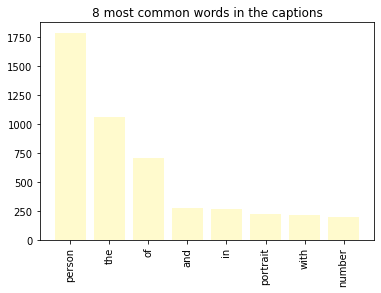

In [0]:
# visualisation
plt.bar(range(8), [elem[1] for elem in most_common[:8]], color = 'lemonchiffon')
plt.xticks(range(8), [elem[0] for elem in most_common[:8]], rotation='vertical')
plt.title('8 most common words in the filtered captions') 

Text(0.5, 1.0, '30 most common words in the captions')

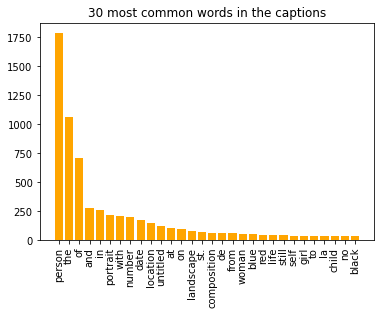

In [0]:
plt.bar(range(30), [elem[1] for elem in most_common[:30]], color = 'orange')
plt.xticks(range(30), [elem[0] for elem in most_common[:30]], rotation='vertical')
plt.title('30 most common words in the captions') 

Text(0.5, 1.0, 'some of the unique words')

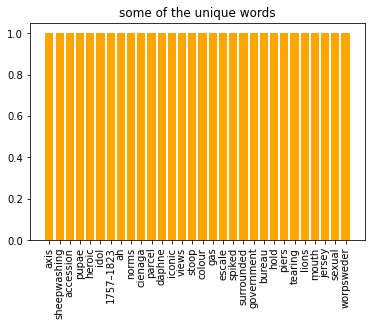

In [0]:
plt.bar(range(30), [elem[1] for elem in most_common[-30:]], color = 'orange')
plt.xticks(range(30), [elem[0] for elem in most_common[-30:]], rotation='vertical')
plt.title('some of the unique words') 

### Decision: 
Since the single-use words are not very significant in the vocabulary, I will filter those out & the words that are only 3 letters long (like the, and, an, etc.), which are often lexical words and thus don't really carry any meaning. This will leave me with a veryy small vocabulary but let's just do it.

In [0]:
filtered_titles = image_df['filtered title'].tolist()

In [0]:
# creating a list of the words that appear more than once
common_words = []
for word, n in most_common:
  if n != 1: 
    common_words.append(word)

print(len(common_words))  

1134


In [0]:
# creating a new list in the dataframe with 
# the filtered titles without the low-frequency 
# and small words. 

frequency_titles = []

for title in filtered_titles:
  new_title = []
  for word in title.split(' '):
    if (word.lower() in common_words) and (len(word)>3) and (word not in new_title):
      new_title.append(word.lower())
  if new_title == []:
    new_title = ["empty"]
  new_title = ' '.join(new_title)
  frequency_titles.append(new_title)

image_df["frequency title"] = frequency_titles 
image_df.head()

,Category,Artist,Title,Year,Image URL,Painting Info URL,file name,path,clean title,filtered title,filtered titles,frequency title
0,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://use2-uploads3.wikiart.org/00123/images...,https://www.wikiart.org/en/charles-courtney-cu...,in-the-luxembourg-garden-1889.jpg,/impressionism/in-the-luxembourg-garden-1889.jpg,In the Luxembourg Garden,In location location location,In location location location,location
1,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://use2-uploads1.wikiart.org/images/keith...,https://www.wikiart.org/en/keith-haring/the-ma...,the-marriage-of-heaven-and-hell-1984.jpg,/neo_expressionism/the-marriage-of-heaven-and-...,The Marriage of Heaven and Hell,The Marriage of Heaven and Hell,The Marriage of Heaven and Hell,marriage hell
2,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://use2-uploads3.wikiart.org/images/j-zse...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,uncle-piacsek-in-front-of-the-black-sideboard-...,/post_impressionism/uncle-piacsek-in-front-of-...,Uncle Piacsek in front of the Black Sideboard,person person in front of the Black Sideboard,person person in front of the Black Sideboard,person front black
3,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://use2-uploads2.wikiart.org/00124/images...,https://www.wikiart.org/en/vadym-meller/monk-f...,monk-for-the-play-mazeppa-1920.jpg,/cubism/monk-for-the-play-mazeppa-1920.jpg,Monk. For the Play Mazeppa,Monk . For the Play Mazeppa,Monk . For the Play Mazeppa,monk play
4,Romanticism,David Wilkie,The Defence of Sarago&#231;a,1828,https://use2-uploads6.wikiart.org/images/david...,https://www.wikiart.org/en/david-wilkie/the-de...,the-defence-of-sarago-a.jpg,/romanticism/the-defence-of-sarago-a.jpg,The Defence of Saragoa,The Defence of Saragoa,The Defence of Saragoa,defence


As you can see we and up with very short captions.

In [0]:
# lets calculate how short
sentlengths = [len(x.split()) for x in frequency_titles]
print("longest caption: ", max(sentlengths), "\nshortest capation: ", 
      min(sentlengths), "\naverage caption length: ", 
      sum(sentlengths)/len(frequency_titles))

longest caption:  10 
shortest capation:  1 
average caption length:  1.7157164869029276


Now, we have to create a `.pickle` file again that contains the path to all the images that contain non-empty captions from `/content/drive/My Drive/AttnGAN/data/wikiart/images` ...

In [0]:
import pickle
import random 
import pandas as pd

In [0]:
# there's still something wrong with how some files
# have been saved (i.e. containing '..jpg' instead of '.jpg')
# let's fix that:

paths = image_df['path'].tolist()

for path in image_df['path'].tolist():
  if path[-4:] != '.jpg':
    print(path)
    newpath = path[:-4] + ".jpg"
    image_df = image_df.replace(path, newpath)

for path in image_df['path'].tolist():
  if path[-5] == '.':
    print(path)
    newpath = path[:-5] + ".jpg"
    print(newpath)
    image_df = image_df.replace(path, newpath) 

paths = image_df['path'].tolist()

/neoclassicism/1814-koch-noahs-dankopfer-anagoria.JPG
/neoclassicism/vernet-claude-joseph-the-night-18th-c-1.JPG
/magic_realism/lethargic-dream-59x80-cmxcm-2002.JPG
/neoclassicism/1804-koch-der-tod-des-oskar-anagoria.JPG
/neoclassicism/1833-koch-serpentaralandschaft-anagoria.JPG
/cubism/epstein-rockdrill.png
/neoclassicism/first-consul-bonaparte-1802.png
/expressionism/otto-mueller-t-nzerin-mit-schleier-von-einem-mann-beobachtet-ca1903.jpeg
/northern_renaissance/quentin-metsys-madonna-col-bambino-1510-25-ca-01.JPG
/high_renaissance/flora-1520.JPG
/cubism/likbez-1920c-1.JPG
/expressionism/otto-mueller-bauerngeh-ft-in-frankreich-ca1916.jpeg
/impressionism/meditation-1889.jpeg
/expressionism/otto-mueller-t-nzerin-mit-schleier-von-einem-mann-beobachtet-ca1903..jpg
/expressionism/otto-mueller-t-nzerin-mit-schleier-von-einem-mann-beobachtet-ca1903.jpg
/expressionism/otto-mueller-bauerngeh-ft-in-frankreich-ca1916..jpg
/expressionism/otto-mueller-bauerngeh-ft-in-frankreich-ca1916.jpg
/impressi

In [0]:
# now create a new list of paths that contains all the 
# paths to the filtered captions
frequency_paths = []

for i, caption in enumerate(frequency_titles):
  if caption != "empty":
    frequency_paths.append(paths[i])

print("number of titles, originally: ", len(frequency_titles))
print("number of non-empty titles: ", len(frequency_paths))

number of titles, originally:  3894
number of non-empty titles:  3178


In [0]:
# create the right format + train and test split
new_paths = []
for path in frequency_paths:
  new_path = path.strip('/')[:-4] # the pickle file doesn't need '.jpg' nor the first slash 
  new_paths.append(new_path)

random.shuffle(new_paths)

# 80% = 2542 (train), 20% = 1352 (test)
train_paths = new_paths[:2542]
test_paths = new_paths[2542:]

In [0]:
# dump them in pickle format
with open('/content/drive/My Drive/AttnGAN/data/wikiart/train/filter_filenames.pickle', 'wb') as f:
  pickle.dump(train_paths, f)

with open('/content/drive/My Drive/AttnGAN/data/wikiart/test/filter_filenames.pickle', 'wb') as f:
  pickle.dump(test_paths, f)

Besides having to create a train/test split, I also need to append the new titles/captions to the captions' `.txt` file of the images. 

In [0]:
first_part = '/content/drive/My Drive/AttnGAN/data/wikiart/text/'

In [0]:
for i, filepath in enumerate(new_paths):
  text_path = first_part + filepath + '.txt'

  with open(text_path, "a") as txt_file:
    txt_file.write("\n")
    txt_file.write(frequency_titles[i])
  txt_file.close()

### Filtering the named entities from the news captions

Now, the news captions have to be filtered too. 

In [0]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import pandas as pd

In [0]:
# fill in the right path of the captions .txt files here 
news_path = '/content/drive/My Drive/AttnGAN/data/wikiart/posneg.txt'

In [0]:
with open(news_path, "r") as f:
  news_captions = f.read().split('\n')
news_captions[0]

'the jury found mr weinstein guilty of two felony sex crimes but acquitted him of charges that he is a sexual predator'

In [0]:
# filter the captions
filtered_news = []
for sentence in news_captions:
  filter_sentence = filter_named_entities(sentence)
  filtered_news.append(filter_sentence)

filtered_news

['The jury found mr . person guilty of number felony sex crimes but acquitted him of charges that he is a sexual predator .',
 'The jury found mr . person guilty of number felony sex crimes but acquitted him of charges that he is a sexual predator . Off to jail . Good',
 'The jury found mr . person guilty of number felony sex crimes but acquitted him of charges that he is a sexual predator . Finally , justice has been served . It is good to know this man is behind bars .',
 'The jury found mr . person guilty of number felony sex crimes but acquitted him of charges that he is a sexual predator . If the women were just normal middle class victims , unlikely the case would even come to trial . No one is talking about this aspect of the case its crucial .',
 'The jury found mr . person guilty of number felony sex crimes but acquitted him of charges that he is a sexual predator . person is a horrible human being but this was not rape . If so then I know many women who have been raped in the

Filtering it on the full vocab of our image dataset:

In [0]:
vocab = [word for word, n in most_common]

In [0]:
new_captions = []

for sentence in filtered_news:
  new_sentence = []
  for word in sentence.split(' '):
    if (word.lower() in vocab) and (len(word)>3) and (word not in new_sentence):
      new_sentence.append(word.lower())
  if new_sentence == []:
    new_sentence = ["empty"]
  new_sentence = ' '.join(new_sentence)
  new_captions.append(new_sentence)

new_captions

['found person number that sexual',
 'found person number that sexual good',
 'found person number that sexual justice good this',
 'found person number that sexual women were just class case even come trial about this',
 'found person number that sexual human this rape many women have their']

Filtering it on the most-common vocab of our image dataset:

In [0]:
new_captions = []

for sentence in filtered_news:
  new_sentence = []
  for word in sentence.split(' '):
    if (word.lower() in common_words) and (len(word)>3) and (word not in new_sentence):
      new_sentence.append(word.lower())
  if new_sentence == []:
    new_sentence = ["empty"]
  new_sentence = ' '.join(new_sentence)
  new_captions.append(new_sentence)

new_captions

['after they person date',
 'about',
 'date',
 'with they thought person',
 'between person during state from',
 'person party date only cross lines',
 'from iowa person dead',
 'back person after white house date colonel',
 'that party first state number',
 'their lines country',
 'party wing from field that',
 'party person',
 'general that person',
 'over general',
 'from',
 'that person number people later',
 'last from',
 'also number date person',
 'moment person first',
 'house that',
 'front russia',
 'triumph that still wing party',
 'country number many around venice carnival',
 'person number that',
 'empty',
 'person country that after']

Now there are even less words from the news captions that appear in the most-common vocabulary of our image dataset, but lets make a new file from them. And also from the filtered captions of the full vocab.
I filtered the lists manually afterwards, since some sentences really dont make any sence. 

In [0]:
%cd '/content/drive/My Drive/AttnGAN/data/wikiart/'
filter_path = 'all_news_captions.txt'

with open(filter_path, 'w') as f:
    for line in new_captions:
      if line != "empty":
        f.write("%s\n" % line)
f.close()

/content/drive/My Drive/AttnGAN/data/wikiart


In [0]:
# I manually took some of them out here.
filtered_captions = ['came after they need person date',
 'senate victory about',
 'date china',
 'with they thought person',
 'between person during state union from office',
 'person party date only cross lines',
 'from iowa person dead',
 'victory strike back person union after white house date colonel',
 'that party first state race number',
 'return their lines holiday country',
 'party liberal wing from field that divided',
 'party look person',
 'general that friend person justice department',
 'over justice department general',
 'from even them',
 'that person number people later found',
 'britain last from united',
 'also number date person',
 'moment person first personal',
 'house have that',
 'nominal front russia attack american',
 'triumph that difficult still wing party',
 'country number cases many around milan venice carnival',
 'found person number that sexual',
 'american',
 'person country that government spread after']

In [0]:
%cd '/content/drive/My Drive/AttnGAN/data/wikiart/'
filter_path = 'news_filtered2.txt'

with open(filter_path, 'w') as f:
    for line in filtered_captions:
      if line != "empty":
        f.write("%s\n" % line)
f.close()

/content/drive/My Drive/AttnGAN/data/wikiart
